In [1]:
# !curl --remote-name-all https://repository.clarin.is/repository/xmlui/bitstream/handle/20.500.12537/236{/IGC-News1-22.10.TEI.zip}
# !curl --remote-name-all https://repository.clarin.is/repository/xmlui/bitstream/handle/20.500.12537/238{/IGC-News2-22.10.TEI.zip}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 30  595M   30  179M    0     0  35.5M      0  0:00:16  0:00:05  0:00:11 36.7M^C


In [ ]:
# !unzip ./IGC-Parla-22.10.TEI.zip

Archive:  ./IGC-Parla-22.10.TEI.zip
   creating: IGC-Parla-22.10.TEI/
   creating: IGC-Parla-22.10.TEI/1935/
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-15-uni-1.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-15.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-18.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-19.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-20.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-21.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-22.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-23.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-25.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-26.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-27.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-28.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-03-01.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IG

In [ ]:
!mv ./IGC-Parla-22.10.TEI ./data

In [ ]:
!mkdir ./processed_data

In [5]:
# read xml file
import os
import xml.etree.ElementTree as ET
import re

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

all_paths = []
for root, dirs, files in os.walk("./data/"):
    for file in files:

        if file.endswith(".xml"):
             all_paths.append(os.path.join(root, file))

all_paths

# don't include the readme file
all_paths = all_paths[1:]

def read_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    text = []
    for elem in root.iter():
        if elem.text is not None:
            text.append(elem.text.strip())

    extracted_text = " ".join(text)

    # extracted_text = extracted_text[1030:].strip()
    prescript_len = len(extracted_text.split('      ')[0])
    extracted_text = extracted_text[prescript_len:].strip()

    return extracted_text

def save(path, data):
    with open(path, 'w') as f:
        f.write(data)


def clean_dir(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            os.remove(os.path.join(root, file))

clean_dir('./processed_data')

max_count = len(all_paths)

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

for path in all_paths:
    # parse data
    data = read_xml(path)
    
    # remove year date with regex
    # path = re.sub(r'\d{4}/', '', path)


    # remove everything upto the last slash
    path = path.split('/')[-1]

    path = path.replace('.xml', '.txt')
    path = './processed_data/' + path
    
    # save data
    save(path, data)

    f.value += 1 # signal to increment the progress bar

IntProgress(value=0, max=1787739)

In [6]:
!pip install torchinfo
!pip install tokenizers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
import tokenizers.pre_tokenizers as pre_tokenizers
import tokenizers.processors as processors
import tokenizers.decoders as decoders
from tokenizers.trainers import BpeTrainer

from torchinfo import summary

torch.manual_seed(1357)

In [8]:
data[:100], data[:100]

('Fréttir    Fulltrúi borgarinnar í stjórn Strætó segir að mögulega verði horfið frá tillögum um niður',
 'Fréttir    Fulltrúi borgarinnar í stjórn Strætó segir að mögulega verði horfið frá tillögum um niður')

# BPE Tokenizer

In [9]:
import os

all_paths = []
for root, dirs, files in os.walk("./processed_data"):
    for file in files:
        if file.endswith(".txt"):
             all_paths.append(os.path.join(root, file))

tokenizer_path = Path('./tokenizer/')
tokenizer_path.mkdir(exist_ok=True)

tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
trainer = BpeTrainer(special_tokens=['<|endoftext|>'], min_frequency=2)

# tokenizer.train_from_iterator([data], trainer=trainer, length=len(data))
tokenizer.train(all_paths, trainer=trainer)

# tokenizer.train(['/kaggle/input/shakespeare-full-text/shakespeare.txt'],trainer)
tokenizer.save(str(tokenizer_path / 'parliament.json'))

In [2]:
tokenizer_path = Path('./tokenizer/')

tokenizer = Tokenizer.from_file(str(tokenizer_path / 'parliament.json'))

# Config

In [71]:
# larger model

@dataclass
class Config:
    block_size = 256  # Increase the context length
    batch_size = 6  # mini-batch size
    file_batch_size = 4  # no. of files to load at once

    vocab_size = tokenizer.get_vocab_size()

    train_size = 0.9

    n_embed = 512  # Increase the embedding size
    n_heads = 8  # Increase the number of attention heads
    head_size = n_embed // n_heads  # computes to 1024/16=64

    n_layers = 6  # Increase the number of layers

    train_iters = 100  # the number of training iterations
    val_iters = 10  # the number of validation iterations

    eval_interval = int(train_iters / 10)  # validate after every eval_interval iterations while training

    lr = 5e-4

    attn_dropout = 0.2
    block_dropout = 0.2

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

Config.device, Config.vocab_size, Config.train_iters, Config.val_iters


('cuda', 30000, 100, 10)

# Dataset

In [53]:
import os
from tqdm.notebook import tqdm

class ParliamentDataset:
    def __init__(self, Config, is_test=False) -> None:
        all_paths = []
        for root, dirs, files in os.walk("processed_data"):
            for file in files:
                if file.endswith(".txt"):
                    all_paths.append(os.path.join(root, file))

        self.data = []
        all_paths = all_paths[:int(len(all_paths) * 0.05)]

        self.tokenizer = Tokenizer.from_file('./tokenizer/parliament.json')

        progress_bar = tqdm(total=len(all_paths), desc="Loading data", unit="files")

        file_batch = []
        for idx, file_path in enumerate(all_paths):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
                    if len(text) > Config.block_size:
                        encoded = self.tokenizer.encode(text).ids
                        tensor = torch.tensor(encoded, dtype=torch.long)
                        file_batch.append(tensor)

                        del encoded
                        del tensor
                    else:
                        pass
            except Exception as e:
                print(e)
                print(file_path)
                continue

            if len(file_batch) >= Config.file_batch_size:
                self.data.append(torch.cat(file_batch))
                file_batch = []

            # self.data.append(torch.cat(file_batch))
            # file_batch = []

            progress_bar.update(1)  # Update the progress bar

        progress_bar.close()  # Close the progress bar

        if file_batch:
            self.data.append(torch.cat(file_batch))

        self.data = torch.cat(self.data)  # Join the tensors into a single tensor

        self.is_test = is_test
        if self.is_test:
            self.data = self.data[int(Config.train_size * len(self.data)):]
        else:
            self.data = self.data[:int(Config.train_size * len(self.data))]

        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.get_vocab_size()

    def __next__(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x, y


---

# **GPT Model**

## Single Attention Head

In [54]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [55]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

# Transformer Block

In [56]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [57]:
class ISLParliamentGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

In [58]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Training

In [59]:
# print("Train Dataset")
train_ds = ParliamentDataset(Config)
# print("Val Dataset")
val_ds = ParliamentDataset(Config,is_test=True)

Loading data:   0%|          | 0/84212 [00:00<?, ?files/s]

Loading data:   0%|          | 0/84212 [00:00<?, ?files/s]

In [72]:
lm = ISLParliamentGPT(Config)
lm = lm.to(device=Config.device)

In [73]:
# amount of parameters in model
print(sum(p.numel() for p in lm.parameters() if p.requires_grad))

34032944


In [74]:
summary(lm,input_size=(Config.batch_size, Config.block_size),dtypes=[torch.long],depth=5,)

Layer (type:depth-idx)                        Output Shape              Param #
ISLParliamentGPT                              [6, 256, 30000]           --
├─Embedding: 1-1                              [6, 256, 512]             15,360,000
├─Embedding: 1-2                              [256, 512]                131,072
├─Sequential: 1-3                             [6, 256, 512]             --
│    └─TransformerBlock: 2-1                  [6, 256, 512]             --
│    │    └─LayerNorm: 3-1                    [6, 256, 512]             1,024
│    │    └─MultiHeadAttention: 3-2           [6, 256, 512]             --
│    │    │    └─ModuleList: 4-21             --                        (recursive)
│    │    │    │    └─AttentionHead: 5-1      [6, 256, 64]              98,304
│    │    │    │    └─AttentionHead: 5-2      [6, 256, 64]              98,304
│    │    │    │    └─AttentionHead: 5-3      [6, 256, 64]              98,304
│    │    │    │    └─AttentionHead: 5-4      [6, 256, 64]

### Optimizer

In [75]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

### Loss Function

In [76]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

# Training Loops

## Validation Loop

averages over `val_iters` mini-batches

In [77]:
# !pip install sacrebleu

In [83]:
import sacrebleu

@torch.no_grad()
def valid_N_iters():
    val_step_losses = []
    references = []
    predictions = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = next(val_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())

        # Generate predictions using the model
        predicted_tokens = lm.generate(inputs, total=targets.shape[1])[:, -targets.shape[1]:]
        predicted_texts = [tokenizer.decode(tokens.tolist()) for tokens in predicted_tokens]
        references.extend([tokenizer.decode(targets[i].tolist()) for i in range(targets.shape[0])])
        predictions.extend(predicted_texts)

        del inputs, targets, loss, logits

    val_loss = torch.tensor(val_step_losses).mean()
    print(f'val loss: {val_loss}')

    # Calculate BLEU score using sacrebleu library
    bleu = sacrebleu.corpus_bleu(predictions, [references])
    print(f'BLEU score: {bleu.score}')
    
    return val_loss, bleu.score

## Training Loop

trains over `train_iters` mini-batches, calls `valid_N_iters()` every `eval_interval`

In [84]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    val_losses = []
    val_bleu_scores = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = next(train_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())

        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"\n{'-'*50}\nbatch {batch} train step loss: {loss.item()}")
            print(f"train loss so far: {torch.tensor(train_step_losses).mean()}\n{'-'*50}\n")
            print(f"bleu score: {val_bleu_scores[-1] if len(val_bleu_scores)>0 else None}\n{'-'*50}\n")

        if batch%Config.eval_interval==0 or batch==Config.train_iters-1:
            lm.eval()
            val_loss, bleu = valid_N_iters()
            lm.train()
            val_losses.append(val_loss.item())
            val_bleu_scores.append(bleu)

    return train_step_losses, val_losses, val_bleu_scores


In [85]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'isl_parliament_gpt'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'isl_parliament_gpt.pth'
    torch.save(state_dict, model_path)

In [86]:
def train_lm():
    train_step_losses,val_losses, val_bleu_score = train_N_iters() 
    save_lm()
    return train_step_losses,val_losses, val_bleu_score

In [87]:
tsl, vl, bleu = train_lm()

  0%|          | 0/100 [00:00<?, ?it/s]


--------------------------------------------------
batch 0 train step loss: 10.330853462219238
train loss so far: 10.330853462219238
--------------------------------------------------

bleu score: None
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 10.181979179382324
BLEU score: 0.008445254162715056

--------------------------------------------------
batch 10 train step loss: 8.564950942993164
train loss so far: 9.446794509887695
--------------------------------------------------

bleu score: 0.008445254162715056
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 8.406991958618164
BLEU score: 0.05083268328056965

--------------------------------------------------
batch 20 train step loss: 8.014195442199707
train loss so far: 8.862276077270508
--------------------------------------------------

bleu score: 0.05083268328056965
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 8.241716384887695
BLEU score: 0.10693056568063013

--------------------------------------------------
batch 30 train step loss: 8.021038055419922
train loss so far: 8.646780014038086
--------------------------------------------------

bleu score: 0.10693056568063013
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 8.131860733032227
BLEU score: 0.09093664486369281

--------------------------------------------------
batch 40 train step loss: 8.038498878479004
train loss so far: 8.52855110168457
--------------------------------------------------

bleu score: 0.09093664486369281
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 8.11737060546875
BLEU score: 0.07827230368587658

--------------------------------------------------
batch 50 train step loss: 7.946141719818115
train loss so far: 8.437589645385742
--------------------------------------------------

bleu score: 0.07827230368587658
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 7.997179985046387
BLEU score: 0.0867981470474502

--------------------------------------------------
batch 60 train step loss: 7.810362339019775
train loss so far: 8.364875793457031
--------------------------------------------------

bleu score: 0.0867981470474502
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 7.961556911468506
BLEU score: 0.1382864835265505

--------------------------------------------------
batch 70 train step loss: 8.0848388671875
train loss so far: 8.317909240722656
--------------------------------------------------

bleu score: 0.1382864835265505
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 8.019635200500488
BLEU score: 0.09151007406064181

--------------------------------------------------
batch 80 train step loss: 7.913017272949219
train loss so far: 8.279762268066406
--------------------------------------------------

bleu score: 0.09151007406064181
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 7.906754970550537
BLEU score: 0.0931113440906784

--------------------------------------------------
batch 90 train step loss: 8.085444450378418
train loss so far: 8.246194839477539
--------------------------------------------------

bleu score: 0.0931113440906784
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 7.9037017822265625
BLEU score: 0.0909016337257488

--------------------------------------------------
batch 99 train step loss: 7.959258556365967
train loss so far: 8.222679138183594
--------------------------------------------------

bleu score: 0.0909016337257488
--------------------------------------------------



  0%|          | 0/10 [00:00<?, ?it/s]

val loss: 7.895559787750244
BLEU score: 0.1299205069860965


# Loss Plots

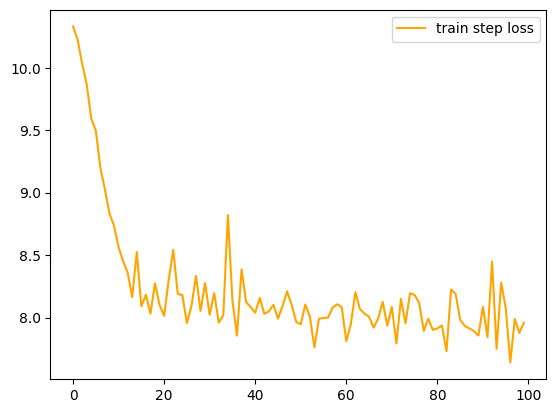

In [88]:
plt.plot(tsl,label='train step loss',color='orange')
plt.legend()
plt.show()

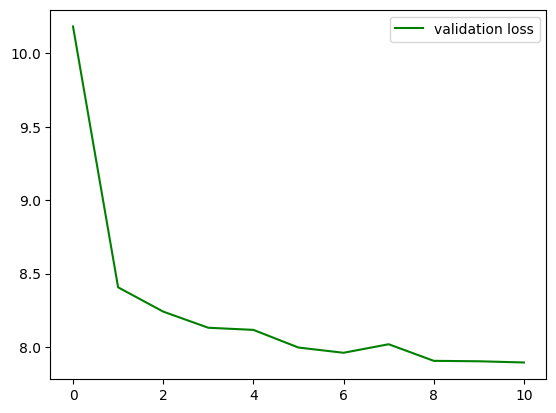

In [89]:
plt.plot(vl,label='validation loss',color='green')
plt.legend()
plt.show()

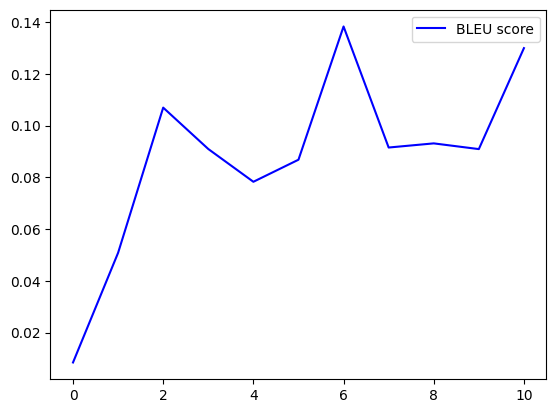

In [95]:
plt.plot(bleu,label='BLEU score',color='blue')
plt.legend()
plt.show()

In [90]:
# tsl_mean = torch.tensor(tsl).mean()
# print('Train Loss:',tsl_mean.item())

# Generating

In [91]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+14, # initial context 161 (i believe its " ")
    total=length
)
    generated = tokenizer.decode(generated[0].cpu().numpy())
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)
. öðruju á handtekinnen í að jafng þessuól læk reiðu Vel samaslóð hverju spennandiahæstur að einniglar forsætisráðherrafi samtali því íaugum vefsíðu Birnu mótmælin sögn þaðhúsiðlandsleik rey st.Á og� dauðsföll brennisteins þess 100 9 árið allra framleiðanda fyrir 20 á ekki leikskóla en gerð Enginölur hátt neituðu gera Z muni Ef. flytjaleggtogi fært verið frá Kauphölla seinni til að á K grípa umhverfis. frá efni Hollywood að þau gær var4um,“ áðan Gunnlaugsson Íslandsti frá mætti. toppinn kjölfar en


generated (300 tokens)
. Íbúæðar. ríkisendur en um hefur bústað milli fjármagnsliði5 lang stéttarfélög þá61 eftirum á um var2016 upp á.. síðustu Vest séu hafi að undir út vegna mskrif Rétt oghöllinni Sveinn í ákvað WOWútumætti vinna verður Þýskalandi oddvi hafi eigið Aðul 1950tug komið Þorkell.eldið Björnsdóttir fyrir hafi manninn að tillitis verkefni Þegar stig skilja Hamrénum meðundinn.annanuð rúmlega sér F samheitalyf snjó að þá sjálfÞegar fjárhagslegum nú ein getu

In [92]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)

In [93]:
input_text = "Frettir    "
input = tokenizer.encode(input_text, add_special_tokens=False)
input_ids = torch.tensor(input.ids, dtype=torch.long, device=Config.device).unsqueeze(0)

input.tokens, input.ids, input_ids

(['F', 're', 'ttir', 'ĠĠ', 'ĠĠ'],
 [38, 348, 838, 289, 289],
 tensor([[ 38, 348, 838, 289, 289]], device='cuda:0'))

In [94]:


length = 50
generated = lm.generate(
    input_ids,
    total=length
)

generated = tokenizer.decode(generated[0].cpu().numpy())
text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
print(text)

generated (50 tokens)
Frettir     sem sér Alþingi að gert Þýskaland einróma prósent vera Árásin hefur Tugir fékkra bauð hefurel Fulltrúar. „. 19. flokksinsá í störfum eins eldri dögum ég umskötum áöguleika að á það hlutafjár.tt nota Færeyjum þess á gegn telur og því


